<a href="https://colab.research.google.com/github/fsternini/anomaly-prediction/blob/development/anomaly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [113]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [114]:
!git clone 'https://github.com/fsternini/anomaly-prediction.git'
%cd 'anomaly-prediction'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'anomaly-prediction'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 1.19 MiB | 3.93 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/anomaly-prediction/anomaly-prediction/anomaly-prediction
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [115]:
!pip install pandas scipy colab-env

In [116]:
from scipy.io import loadmat
from google.colab import drive
import colab_env
import os,sys
from imblearn.over_sampling import SMOTE

drive.mount('/content/drive')

dataset_path = os.environ["ANOMALY_DATASET"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
file_name = 'C_Mod_for_nn.mat'

data = loadmat(os.path.join(dataset_path,file_name))
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'shot', 'time', 'time_until_disrupt', 'v_loop', 'z_error', 'signal_names'])


In [118]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Oct  6 14:21:28 2019', '__version__': '1.0', '__globals__': [], 'Greenwald_fraction': array([[2.61671424e-01],
       [1.93636477e-01],
       [3.12397703e-21],
       ...,
       [1.67424858e-01],
       [1.69788092e-01],
       [1.66034207e-01]]), 'Mirnov_norm_btor': array([[1.2390554 ],
       [1.15398717],
       [3.54094219],
       ...,
       [0.16784951],
       [0.18845347],
       [0.1710373 ]]), 'Te_peaking_ECE': array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]]), 'beta_p': array([[ 0.14727603],
       [ 0.19911849],
       [-0.01403902],
       ...,
       [ 0.09726767],
       [ 0.10503101],
       [ 0.09966871]]), 'ip_error_normalized': array([[-0.1559327 ],
       [-0.21475341],
       [-0.66040082],
       ...,
       [-0.01495537],
       [-0.01148414],
       [-0.01281592]]), 'kappa': array([[1.57228386],
       [1.55385911],
       [1.69113302],
    

In [119]:
columns = []
for d in data["signal_names"]:
  columns.append(d[0][0])
print(columns)

['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'v_loop', 'z_error']


In [120]:
data_filt = {key: value for key, value in data.items() if '__' not in key}
data_filt.pop("signal_names")
#print(data_filt)

array([[array(['Greenwald_fraction'], dtype='<U18')],
       [array(['Mirnov_norm_btor'], dtype='<U16')],
       [array(['Te_peaking_ECE'], dtype='<U14')],
       [array(['beta_p'], dtype='<U6')],
       [array(['ip_error_normalized'], dtype='<U19')],
       [array(['kappa'], dtype='<U5')],
       [array(['li'], dtype='<U2')],
       [array(['lower_gap'], dtype='<U9')],
       [array(['n_equal_1_normalized'], dtype='<U20')],
       [array(['q95'], dtype='<U3')],
       [array(['radiated_fraction'], dtype='<U17')],
       [array(['v_loop'], dtype='<U6')],
       [array(['z_error'], dtype='<U7')]], dtype=object)

In [121]:
import numpy as np
for key, value in data_filt.items():
  data_filt[key]= np.squeeze(value)

In [122]:
import pandas as pd

df = pd.DataFrame(data_filt)
df.head()

,Greenwald_fraction,Mirnov_norm_btor,Te_peaking_ECE,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,shot,time,time_until_disrupt,v_loop,z_error
0,2.616714e-01,1.239055,NaN,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,1150915029,0.2850,0.0141,4.186112,-0.004279
1,1.936365e-01,1.153987,NaN,0.199118,-0.214753,1.553859,1.470170,0.077982,0.001154,5.151639,1.701884,1150915029,0.2900,0.0091,3.770813,0.000107
2,3.123977e-21,3.540942,NaN,-0.014039,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,1150915029,0.2950,0.0041,7.111877,0.004702
3,1.853891e-01,0.208537,NaN,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,1120131006,0.1895,0.0150,-2.671509,-0.007156
4,1.804675e-01,0.194072,NaN,0.024498,-0.246736,1.388904,1.564471,0.106611,0.001136,4.985343,0.510057,1120131006,0.1945,0.0100,-2.581421,-0.018531


In [123]:
df.set_index(["shot","time"],inplace=True)

In [124]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  
shot       time                                                               
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279  
           0.2900           1.701884              0.0091  3.770813  0.000107  
           0.2950           0.276097              0.0041  7.111877  0.004702  
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156  
           0.1945           0.510057              0.0100 -2.581421 -0.018531

In [125]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
dtype: int64

In [126]:
df[df['time_until_disrupt']<0.03].count()

Greenwald_fraction      5941
Mirnov_norm_btor        5959
Te_peaking_ECE          1925
beta_p                  5959
ip_error_normalized     5959
kappa                   5958
li                      5959
lower_gap               5959
n_equal_1_normalized    5959
q95                     5956
radiated_fraction       5959
time_until_disrupt      5959
v_loop                  5959
z_error                 5959
dtype: int64

In [127]:
df["disrupt_30ms"]=False

In [128]:
df.loc[df['time_until_disrupt']<0.03, "disrupt_30ms"]=True

In [129]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  \
shot       time                                                                
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279   
           0.2900           1.701884              0.0091  3.770813  0.000107   
           0.2950           0.276097              0.0041  7.111877  0.004702   
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156   
           0.1945           0.510057              0.0100 -2.581421 -0.018531   

                   disrupt_30ms  
shot       time                  
1150915029 0.2850          True  
           0.2900          True  
           0.2950          True  
1120131006 0.1895          True  
           0.1945          True

In [130]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
disrupt_30ms            479692
dtype: int64

In [131]:
df.isna().sum()

Greenwald_fraction         455
Mirnov_norm_btor            72
Te_peaking_ECE          141680
beta_p                       0
ip_error_normalized          0
kappa                        1
li                           0
lower_gap                    0
n_equal_1_normalized         0
q95                          3
radiated_fraction          532
time_until_disrupt      400863
v_loop                       0
z_error                      0
disrupt_30ms                 0
dtype: int64

In [132]:
df.drop(columns=["time_until_disrupt","Te_peaking_ECE"],inplace=True)

In [133]:
df.isna().sum()

Greenwald_fraction      455
Mirnov_norm_btor         72
beta_p                    0
ip_error_normalized       0
kappa                     1
li                        0
lower_gap                 0
n_equal_1_normalized      0
q95                       3
radiated_fraction       532
v_loop                    0
z_error                   0
disrupt_30ms              0
dtype: int64

In [134]:
df.dropna(inplace=True)

In [135]:
df.count()

Greenwald_fraction      478630
Mirnov_norm_btor        478630
beta_p                  478630
ip_error_normalized     478630
kappa                   478630
li                      478630
lower_gap               478630
n_equal_1_normalized    478630
q95                     478630
radiated_fraction       478630
v_loop                  478630
z_error                 478630
disrupt_30ms            478630
dtype: int64

In [136]:
df["disrupt_30ms"].value_counts()

disrupt_30ms
False    472692
True       5938
Name: count, dtype: int64

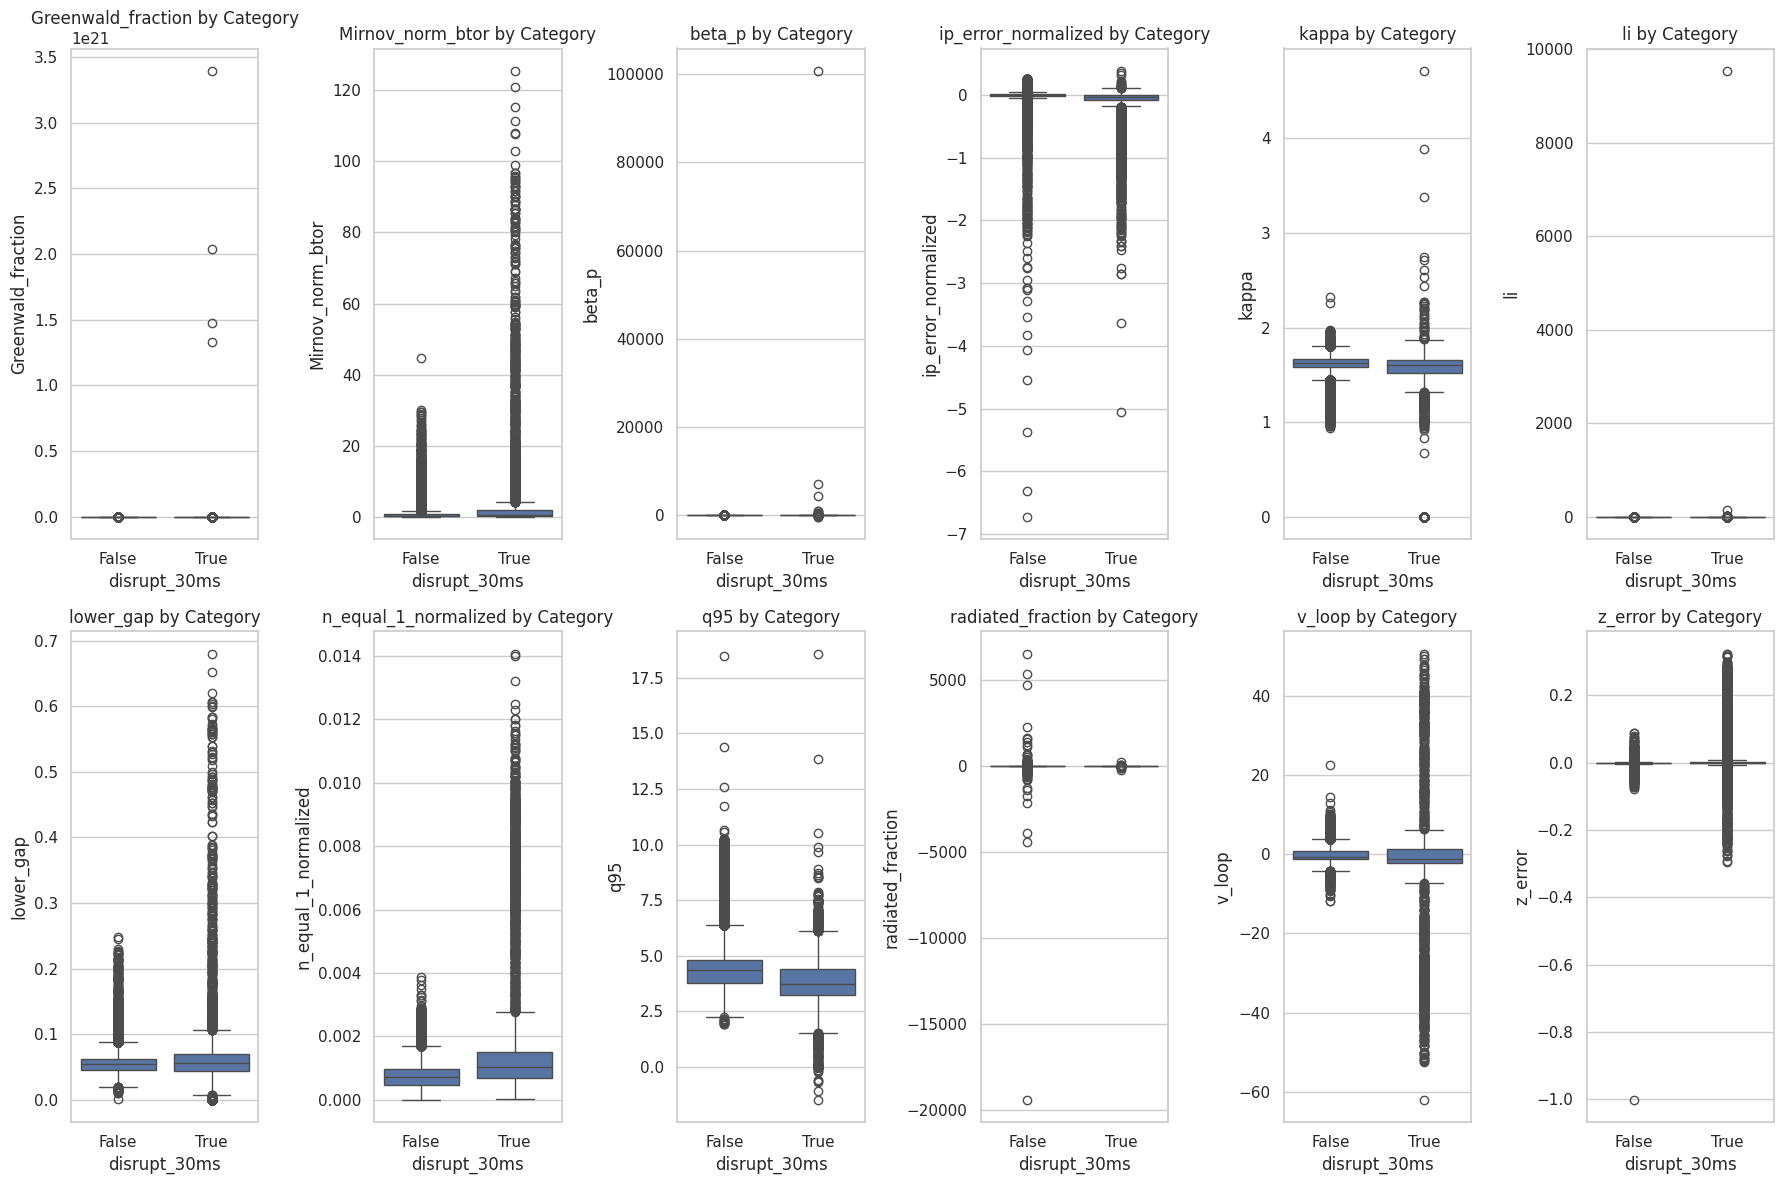

In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for index, feature in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=df)
    plt.title(f'{feature} by Category')

plt.tight_layout()
plt.show()

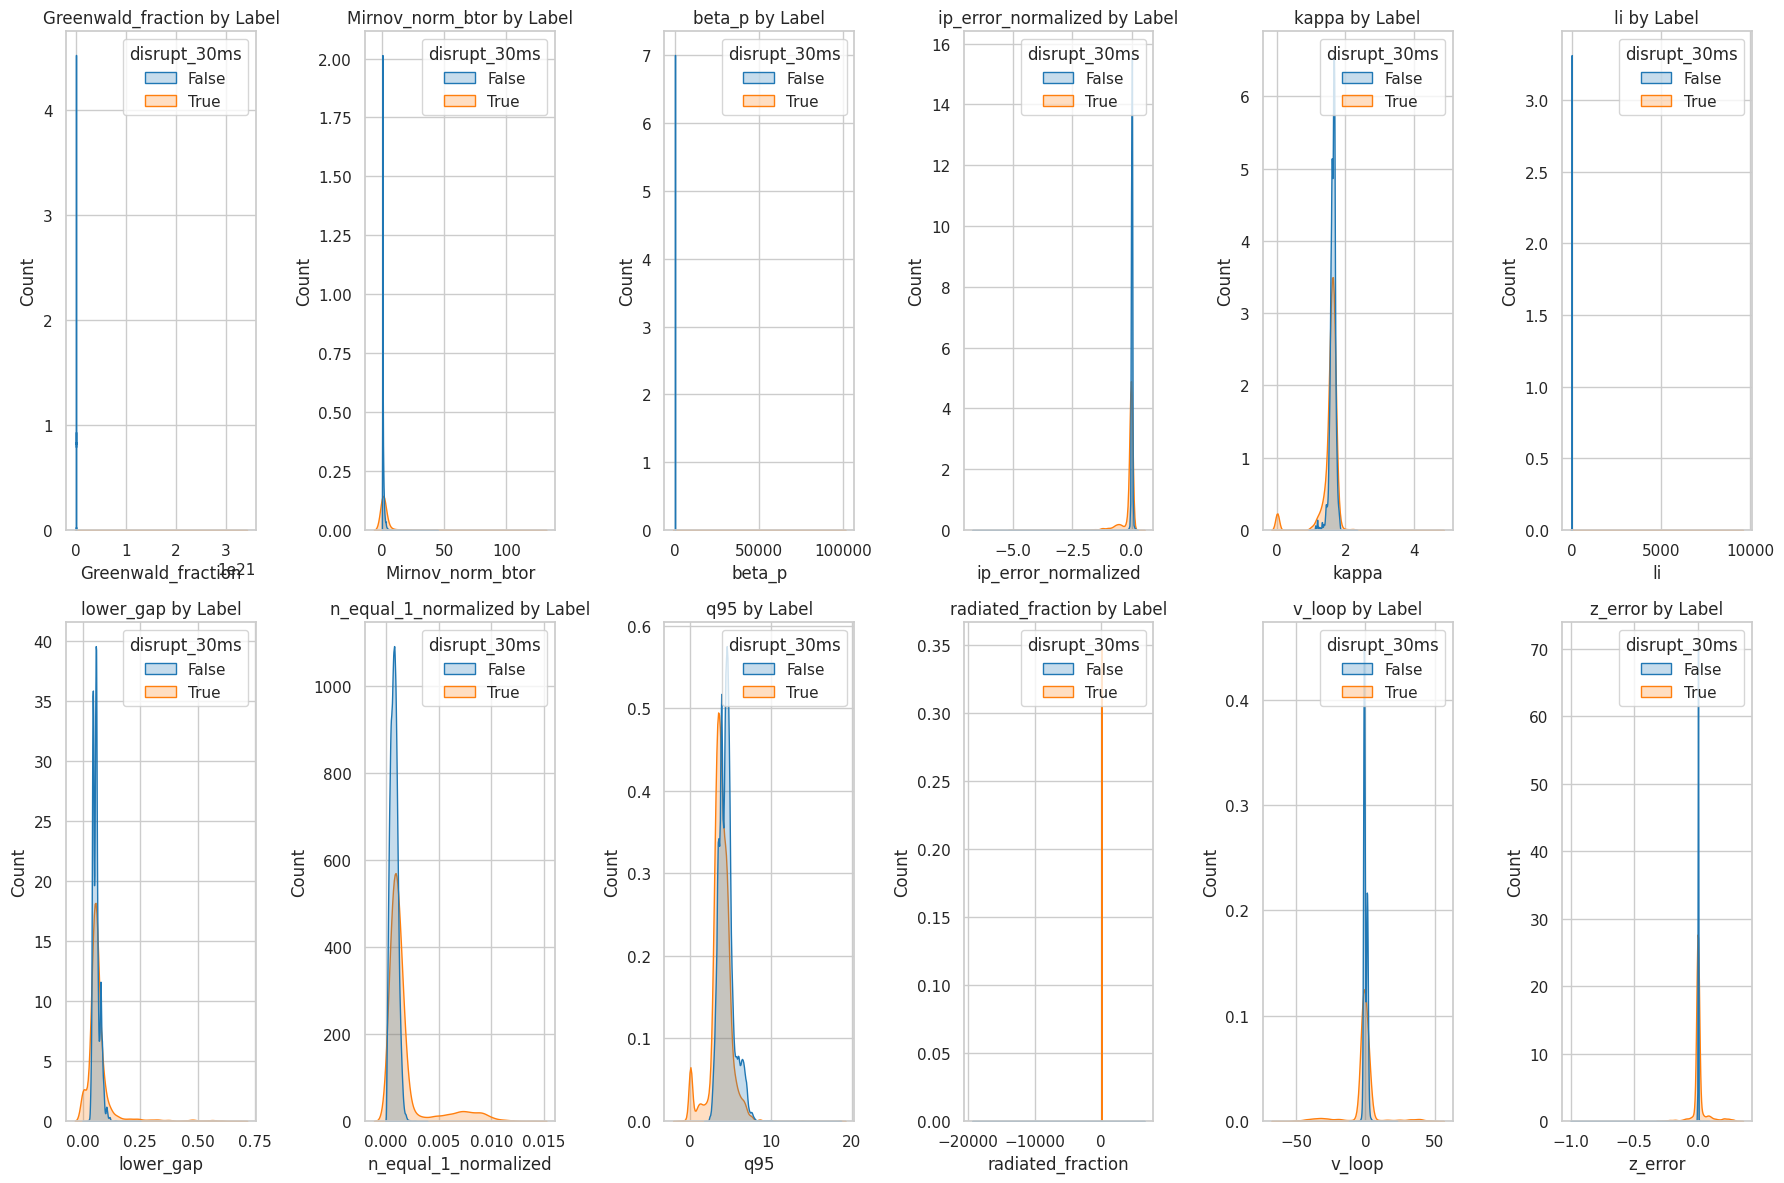

In [138]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

numeric_columns = df.select_dtypes(include='number').columns
num_plots = len(numeric_columns)

for index, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, int(num_plots/2), index)
    sns.kdeplot(data=df, x=col, hue='disrupt_30ms', fill=True, common_norm=False, palette='tab10')
    plt.title(f'{col} by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [139]:
from sklearn.model_selection import train_test_split


In [140]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['disrupt_30ms'], random_state=42)

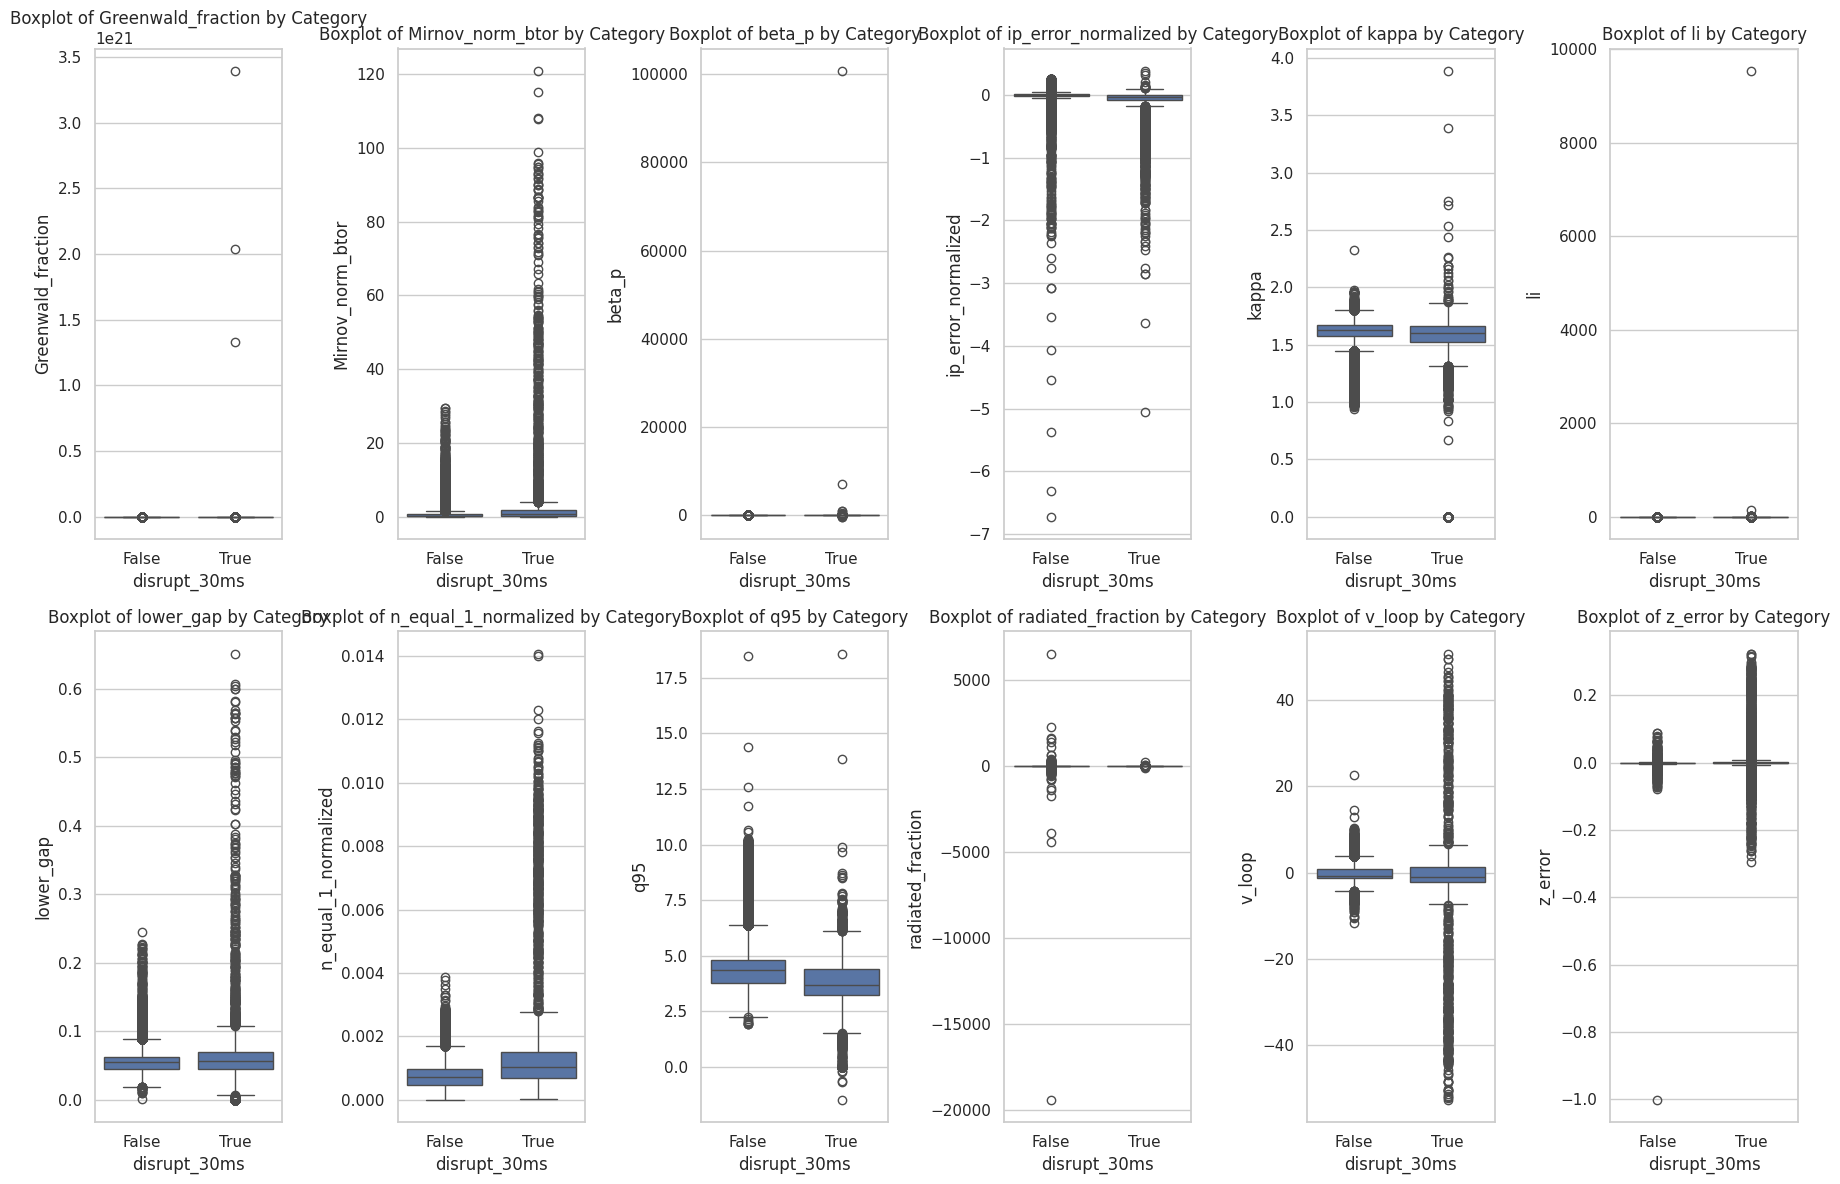

In [141]:
plt.figure(figsize=(18, 12))

for index, feature in enumerate(train_df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(train_df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature} by Category')

plt.tight_layout()
plt.show()

#Anomaly detection

In [269]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

X_train = np.array(train_df.drop(columns=["disrupt_30ms"]))
y_train = np.array(train_df["disrupt_30ms"])
X_test = np.array(test_df.drop(columns=["disrupt_30ms"]))
y_test = np.array(test_df["disrupt_30ms"])
print(X_train, y_train)

[[ 2.65229911e-01  1.13349831e+00  5.72879255e-01 ...  2.88943172e-01
  -9.53796387e-01 -3.83627281e-04]
 [ 2.69912332e-01  4.98025894e-01  3.64975333e-01 ...  1.84047997e-01
   6.34981275e-01  1.20978853e-04]
 [ 1.96628153e-01  9.11588430e-01  4.24721807e-01 ...  1.11010563e+00
   1.14135742e-01 -2.96041166e-04]
 ...
 [ 4.71657485e-01  4.10500541e-02  4.65717167e-01 ...  4.80820179e-01
  -8.43573391e-01 -2.24022823e-03]
 [ 5.44782221e-01  7.98882484e-01  3.32017183e-01 ...  7.07769513e-01
  -1.36608887e+00  9.83926235e-04]
 [ 1.60234004e-01  2.03665543e+00  3.26759398e-01 ...  6.23595491e-02
   2.20718145e+00 -3.36552825e-04]] [False False False ... False False False]


In [143]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [144]:
isolation_forest = IsolationForest(max_samples=100, random_state=42)
isolation_forest.fit(scaled_data)

IsolationForest(max_samples=100, random_state=42)

In [164]:
# Predict anomalies: -1 indicates an anomaly, 1 indicates normal
y_pred = isolation_forest.predict(scaled_data)
print(y_pred)
print(np.unique(y_pred,return_counts=True))

[ 1  1  1 ...  1 -1  1]
(array([-1,  1]), array([ 22825, 312216]))


In [162]:
y_train_isfor=y_train.astype(int)*(-2)+1
print(y_train_isfor)
print(np.unique(y_train_isfor,return_counts=True))

[1 1 1 ... 1 1 1]
(array([-1,  1]), array([  4157, 330884]))


In [165]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
cm = confusion_matrix(y_train_isfor, y_pred, labels=[1, -1])

# Calculate precision and recall scores
precision = precision_score(y_train_isfor, y_pred, pos_label=-1)
recall = recall_score(y_train_isfor, y_pred, pos_label=-1)

# Display results
print("Confusion Matrix:")
print(cm)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred, labels=[1, -1], target_names=['Normal', 'Anomalous']))

Confusion Matrix:
[[309947  20937]
 [  2269   1888]]

Precision: 0.08
Recall: 0.45

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.01      0.55      0.01      4157
   Anomalous       0.00      0.00      0.00         0

   micro avg       0.01      0.55      0.01      4157
   macro avg       0.00      0.27      0.01      4157
weighted avg       0.01      0.55      0.01      4157



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


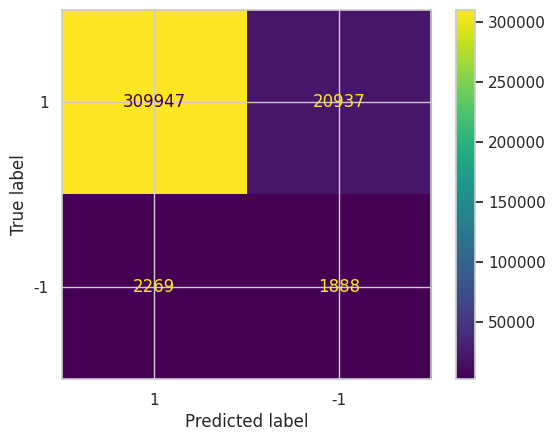

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,-1])
disp.plot()
plt.show()

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [177]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_train)

In [178]:
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:", explained_variance)


Explained Variance Ratio: [1.00000000e+00 5.90762925e-34]


In [179]:
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df.head()

,Principal Component 1,Principal Component 2
0,-2.018423e+16,0.037945
1,-2.018423e+16,-0.197858
2,-2.018423e+16,-0.143824
3,-2.018423e+16,-0.233500
4,-2.018423e+16,-0.202396


In [180]:
pca_df["disrupt_30ms"] = train_df["disrupt_30ms"].reset_index(drop=True)
pca_df["disrupt_30ms"].unique()

array([False,  True])

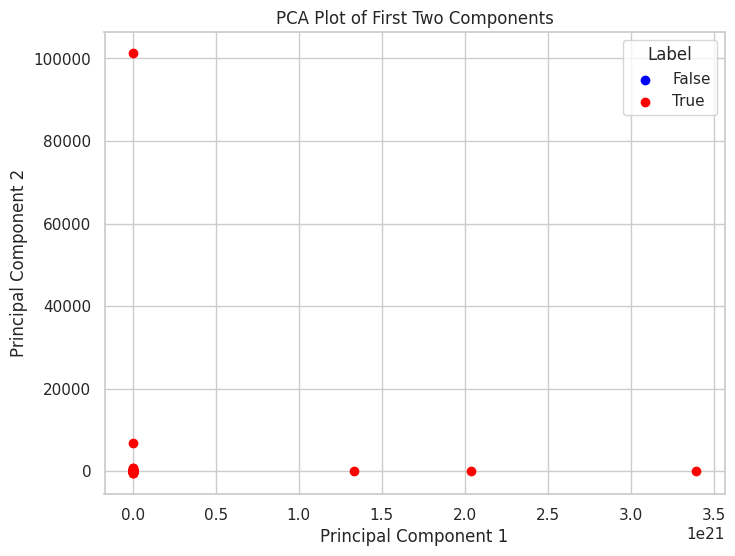

In [181]:

# Plot the first two principal components with colors based on the label
plt.figure(figsize=(8, 6))
colors = {False: 'blue', True: 'red'}
for label in pca_df["disrupt_30ms"].unique():
    subset = pca_df[pca_df["disrupt_30ms"] == label]
    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], c=colors[label], label=label)

#subset = pca_df[pca_df["disrupt_30ms"] == True]
#plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], c=colors[True], label="True")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.title('PCA Plot of First Two Components')
plt.grid(True)
plt.show()

In [ ]:
df.groupby("disrupt_30ms").count()

,Greenwald_fraction,Mirnov_norm_btor,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,v_loop,z_error
disrupt_30ms,,,,,,,,,,,,
False,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692,472692
True,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938,5938


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support


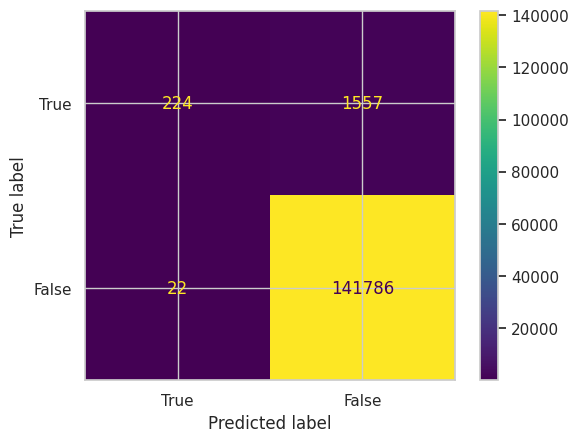

              precision    recall  f1-score   support

        True       0.91      0.13      0.22      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.95      0.56      0.61    143589
weighted avg       0.99      0.99      0.98    143589



In [186]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

In [187]:
from imblearn.over_sampling import SMOTE

In [188]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

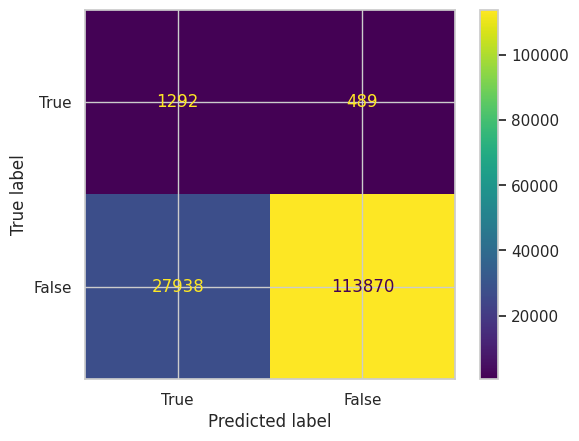

              precision    recall  f1-score   support

        True       0.04      0.73      0.08      1781
       False       1.00      0.80      0.89    141808

    accuracy                           0.80    143589
   macro avg       0.52      0.76      0.49    143589
weighted avg       0.98      0.80      0.88    143589



In [189]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
x_res, y_res = resampler.fit_resample(X_train,y_train)
clf.fit(x_res, y_res)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

In [192]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [220]:
model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf_xgb.fit(x_train_xgb, y_train_xgb, xgbclassifier__eval_set=[(x_eval_xgb, y_eval_xgb)])
y_pred = clf_xgb.predict(X_test)

[0]	validation_0-logloss:0.12116
[1]	validation_0-logloss:0.09749
[2]	validation_0-logloss:0.08085
[3]	validation_0-logloss:0.06891
[4]	validation_0-logloss:0.06056
[5]	validation_0-logloss:0.05442
[6]	validation_0-logloss:0.04977
[7]	validation_0-logloss:0.04614
[8]	validation_0-logloss:0.04371
[9]	validation_0-logloss:0.04196
[10]	validation_0-logloss:0.04052
[11]	validation_0-logloss:0.03930
[12]	validation_0-logloss:0.03849
[13]	validation_0-logloss:0.03770
[14]	validation_0-logloss:0.03718
[15]	validation_0-logloss:0.03683
[16]	validation_0-logloss:0.03653
[17]	validation_0-logloss:0.03623
[18]	validation_0-logloss:0.03592
[19]	validation_0-logloss:0.03567
[20]	validation_0-logloss:0.03544
[21]	validation_0-logloss:0.03501
[22]	validation_0-logloss:0.03470
[23]	validation_0-logloss:0.03453
[24]	validation_0-logloss:0.03444
[25]	validation_0-logloss:0.03423
[26]	validation_0-logloss:0.03406
[27]	validation_0-logloss:0.03393
[28]	validation_0-logloss:0.03379
[29]	validation_0-loglos

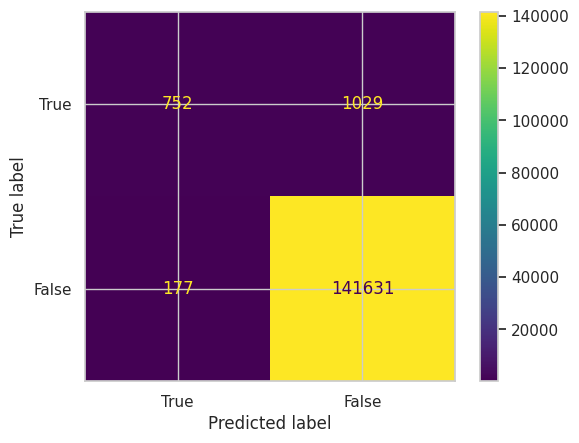

              precision    recall  f1-score   support

        True       0.81      0.42      0.55      1781
       False       0.99      1.00      1.00    141808

    accuracy                           0.99    143589
   macro avg       0.90      0.71      0.78    143589
weighted avg       0.99      0.99      0.99    143589



In [221]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

[0]	validation_0-logloss:0.56939
[1]	validation_0-logloss:0.49469
[2]	validation_0-logloss:0.44041
[3]	validation_0-logloss:0.40594
[4]	validation_0-logloss:0.37956
[5]	validation_0-logloss:0.35893
[6]	validation_0-logloss:0.34451
[7]	validation_0-logloss:0.33360
[8]	validation_0-logloss:0.32265
[9]	validation_0-logloss:0.31661
[10]	validation_0-logloss:0.30635
[11]	validation_0-logloss:0.29962
[12]	validation_0-logloss:0.29443
[13]	validation_0-logloss:0.28866
[14]	validation_0-logloss:0.28268
[15]	validation_0-logloss:0.27828
[16]	validation_0-logloss:0.27199
[17]	validation_0-logloss:0.26993
[18]	validation_0-logloss:0.26587
[19]	validation_0-logloss:0.26185
[20]	validation_0-logloss:0.25766
[21]	validation_0-logloss:0.25497
[22]	validation_0-logloss:0.25333
[23]	validation_0-logloss:0.24855
[24]	validation_0-logloss:0.24627
[25]	validation_0-logloss:0.24327
[26]	validation_0-logloss:0.24188
[27]	validation_0-logloss:0.23854
[28]	validation_0-logloss:0.23373
[29]	validation_0-loglos

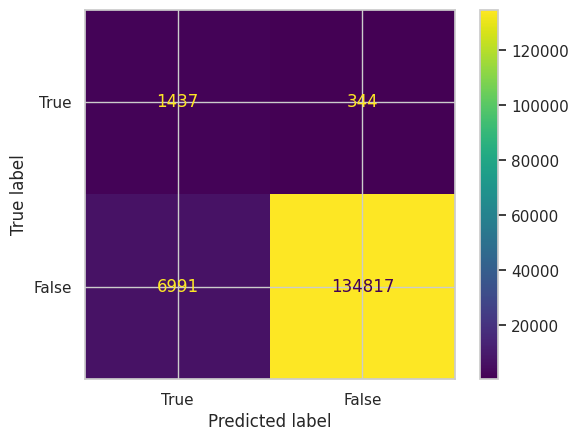

              precision    recall  f1-score   support

        True       0.17      0.81      0.28      1781
       False       1.00      0.95      0.97    141808

    accuracy                           0.95    143589
   macro avg       0.58      0.88      0.63    143589
weighted avg       0.99      0.95      0.96    143589



In [222]:
model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
x_train_xgb,y_train_xgb = resampler.fit_resample(x_train_xgb,y_train_xgb)
clf_xgb.fit(x_train_xgb, y_train_xgb, xgbclassifier__eval_set=[(x_eval_xgb, y_eval_xgb)])
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.7852068114906281


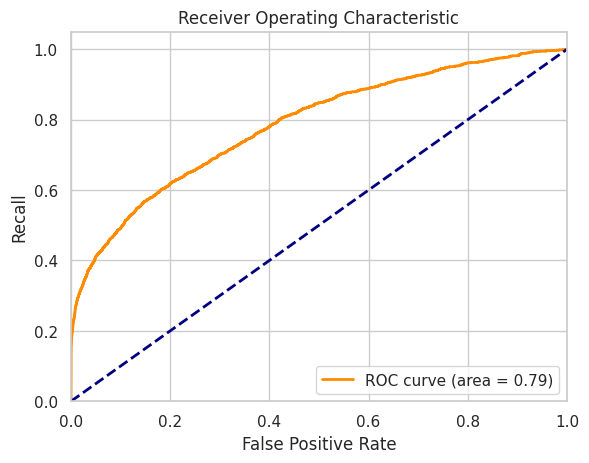

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


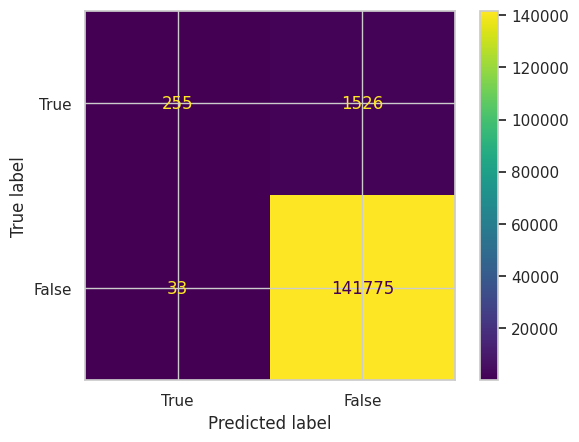

              precision    recall  f1-score   support

        True       0.89      0.14      0.25      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.94      0.57      0.62    143589
weighted avg       0.99      0.99      0.99    143589



In [250]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.8037182606965612


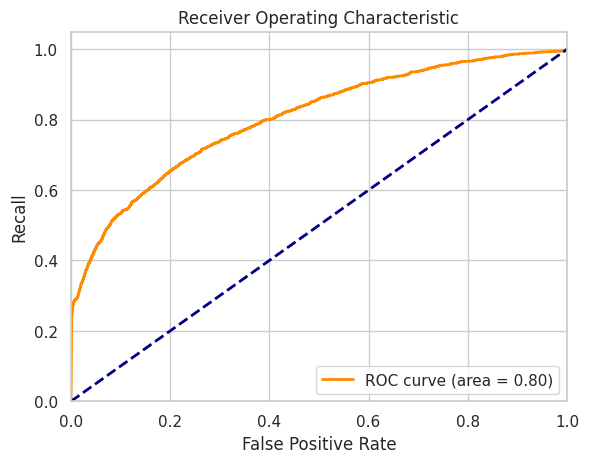

In [251]:
from sklearn.naive_bayes import GaussianNB
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

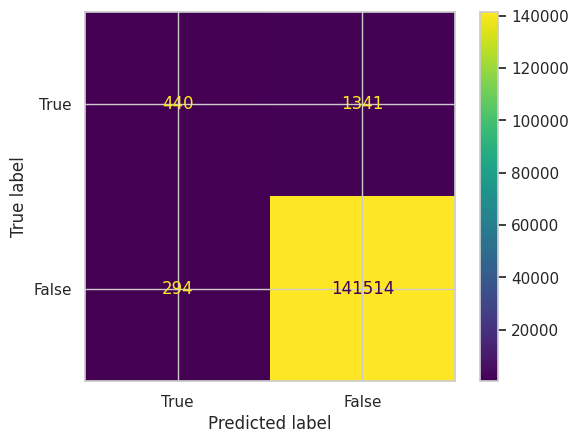

              precision    recall  f1-score   support

        True       0.60      0.25      0.35      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.80      0.62      0.67    143589
weighted avg       0.99      0.99      0.99    143589



In [252]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.7331588486235955


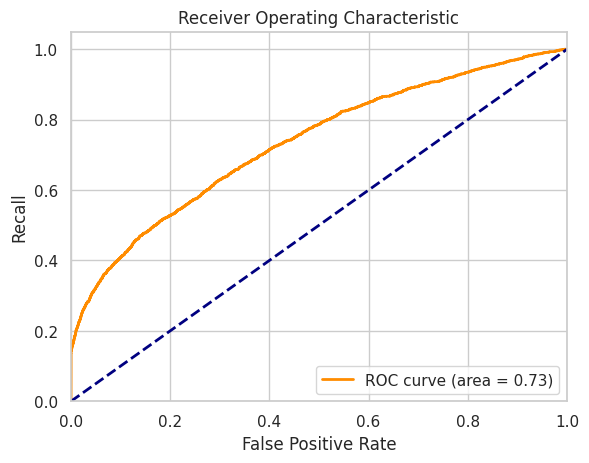

In [253]:
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

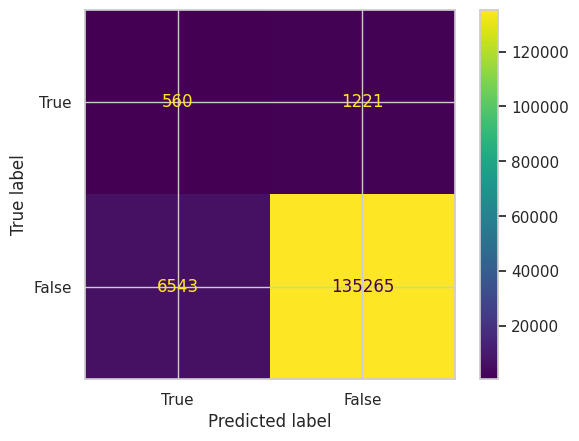

              precision    recall  f1-score   support

        True       0.08      0.31      0.13      1781
       False       0.99      0.95      0.97    141808

    accuracy                           0.95    143589
   macro avg       0.53      0.63      0.55    143589
weighted avg       0.98      0.95      0.96    143589



In [254]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

In [266]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [270]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [271]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [272]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
9423/9423 [==============================] - 26s 3ms/step - loss: 0.0558 - accuracy: 0.9879 - val_loss: 0.0467 - val_accuracy: 0.9897
Epoch 2/50
9423/9423 [==============================] - 19s 2ms/step - loss: 0.0429 - accuracy: 0.9902 - val_loss: 0.0434 - val_accuracy: 0.9901
Epoch 3/50
9423/9423 [==============================] - 20s 2ms/step - loss: 0.0415 - accuracy: 0.9904 - val_loss: 0.0432 - val_accuracy: 0.9903
Epoch 4/50
9423/9423 [==============================] - 20s 2ms/step - loss: 0.0407 - accuracy: 0.9904 - val_loss: 0.0436 - val_accuracy: 0.9904
Epoch 5/50
9423/9423 [==============================] - 20s 2ms/step - loss: 0.0400 - accuracy: 0.9906 - val_loss: 0.0430 - val_accuracy: 0.9905
Epoch 6/50
9423/9423 [==============================] - 22s 2ms/step - loss: 0.0395 - accuracy: 0.9906 - val_loss: 0.0433 - val_accuracy: 0.9904
Epoch 7/50
9423/9423 [==============================] - 20s 2ms/step - loss: 0.0392 - accuracy: 0.9907 - val_loss: 0.0437 - val_ac

4488/4488 [==============================] - 16s 3ms/step
ROC AUC: 0.9185978991419894


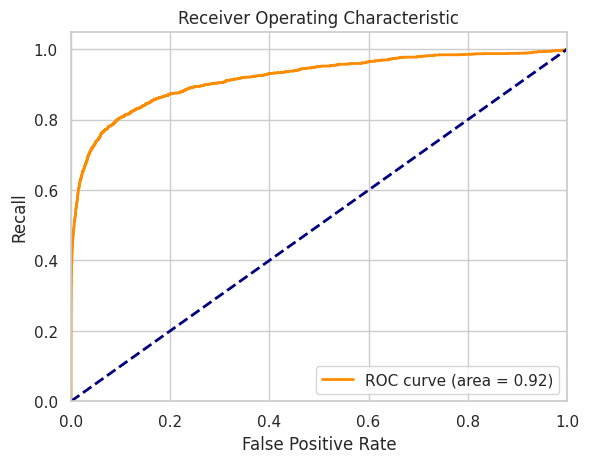

In [281]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [279]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

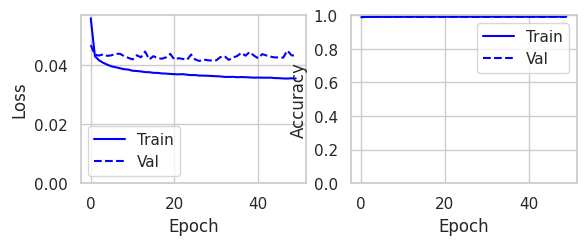

In [280]:
plot_metrics(history)